In [1]:
from __future__ import print_function, division
import sys
sys.path.insert(0, 'lib')
import numpy as np
import random
import pydicom
import os
import matplotlib.pyplot as plt
import pickle
import math
import pydicom
from utils import make_giant_mat, make_dictionary, make_echo_dict
from shutil import copyfile
import nibabel as nib
import scipy.ndimage as ndimage
from scipy.stats import pearsonr, spearmanr

from difference_map_utils import make_difference
from cluster_utils import threshold_diffmaps, strip_empty_lines, resize
from lesion_utils import *
from inference_utils import run_inference
from make_inference_csv import *
from compare_segmentations import get_dice_scores, get_jaccard_indices, compare_region_means, compare_region_changes
from loss_functions import coefficient_of_variation


Using TensorFlow backend.


# Specify which subjects you want to analyze using their OAI Patient ID

In [2]:
with open('/data/dominik_data/train_val_test/pid_train.pickle', 'rb') as f:    
    pid_train = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_val.pickle', 'rb') as f:    
    pid_val = pickle.load(f)
      
with open('/data/dominik_data/train_val_test/pid_test.pickle', 'rb') as f:    
    pid_test = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2.pickle', 'rb') as f:
    pid_expert2 = pickle.load(f)
    
with open('/data/dominik_data/train_val_test/pid_test_expert2_years.pickle', 'rb') as f:
    pid_expert2_yrs = pickle.load(f)

print(pid_test)
print()
print(pid_expert2)
print(pid_expert2_yrs)

['9543086' '9123289' '9260036' '9435250' '9909311' '9518827' '9013634'
 '9245760' '9458093' '9405107' '9120358' '9279874' '9376146' '9529761']

['9435250' '9013634' '9909311' '9279874' '9260036']
[4 8 8 4 8]


# Make Pandas Data Frame and CSV file to specify which image files you want to have analyzed


In [3]:
predict_pd = make_expert_csv_all_years(pID=pid_test,img_dir='/data/kevin_data/images', dir_to_save='/data/kevin_data/predicted')

expert1_pd = make_expert_csv_all_years(pID=pid_test, img_dir='/data/kevin_data/images',dir_to_save='/data/kevin_data/qmetric')

# We only have segmentations for one timepoint for the subjects segmented by expert2 and these are nifti files
expert2_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/expert2', 
                                            seg_provided=True, 
                                            seg_format = "numpy")

predict_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/predicted', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')

expert1_subset_pd = make_expert_csv_specific_years(pID=pid_expert2, 
                                            years=pid_expert2_yrs, 
                                            img_dir='/data/kevin_data/images', 
                                            dir_to_save='/data/kevin_data/qmetric', 
                                            seg_provided=True, 
                                            seg_format = "numpy",
                                            csv_filename = 'file_paths_subset.csv')
# for f in np.array(expert2_pd.image_dir):
#     print(f)


# Generate Segmentations and T2 maps for your MESE images
- If you provide a value for the 'expert_pd' argument, it will use your provided segmentations

- If you provide a value for the 'to_segment_pd' argument, it will automatically segment the cartilage and then use that auto-segmentation to generate the T2 maps. By default, this uses our trained model, but model weights can be changed via the 'model_weights_file' argument and the model can be changed by altering the inference.get_model function in inference.py. 

- In addition to generating 3D T2 maps, it also provides the segmentations used to generate those T2 maps as 3D numpy arrays and json files that summarize the avg T2 value in each anatomical region of the cartilage plate

- These results are all saved in the destinations specied in your Pandas dataframe (expert_pd or to_segment_pd) that you made in the previous step

In [4]:
# run_inference(to_segment_pd = predict_pd)
              
# run_inference(expert_pd = expert1_pd)
              
# run_inference(expert_pd = expert2_pd)

# We don't need to generate additional segmentations for the 'predict_subset_pd' or 'expert1_subset_pd' 
# because they are already generated as part of the 'predict_pd' and 'expert1_pd'

In [5]:
# Flip the expert segmentations if you haven't already
# for file in os.listdir('/data/kevin_data/expert2/segmentations'):
#     if file[-4:]=='.npy':
#         temp = np.load(os.path.join('/data/kevin_data/expert2/segmentations',file))
#         temp = np.flip(temp, axis = 0)
#         np.save(os.path.join('/data/kevin_data/expert2/segmentations',file),temp)

# Use cluster analysis to identify cartilage lesions developing over time
<img src="ClusterAnalysisExample.png" alt="Drawing" style="width: 200px;"/>

Find the percentage of the femoral cartilage surface area that is affected by cartilage lesions. In this context, a lesion is a localized area of cartilage that has increased in T2 value over time more than the surrounding area. You can adjust the settings in calculate_group_lesion_area() to make the criteria for lesions more or less strict based on how large a cluster must be and how much the T2 value must increase. 

Lesions are identified using methods adapted from the following manuscript:

Monu, Uchechukwuka D., et al. "Cluster analysis of quantitative MRI T2 and T1ρ relaxation times of cartilage identifies differences between healthy and ACL-injured individuals at 3T." Osteoarthritis and cartilage 25.4 (2017): 513-520.



In [6]:
paths = np.array(predict_pd.t2_projected_path)
paths = [i + '.pickle' for i in paths]
source1_time1 = np.sort([i for i in paths if i[-12]=='4'])
source1_time2 = np.sort([i for i in paths if i[-12]=='8'])

paths = np.array(expert1_pd.t2_projected_path)
paths = [i + '.pickle' for i in paths]
source2_time1 = np.sort([i for i in paths if i[-12]=='4'])
source2_time2 = np.sort([i for i in paths if i[-12]=='8'])


percentLesion_expert1 = calculate_group_lesion_area(timepoint1=source2_time1,
                                                     timepoint2=source2_time2, 
#                                                      value_threshold = 9,
                                                     sigma_multiple = 1,
#                                                      area_value_threshold = 12.4,
                                                     area_fraction_threshold = .01, 
                                                     area_percentile_threshold = None,
                                                     display=False,
                                                     save_path_list=None)

percentLesion_predict = calculate_group_lesion_area(timepoint1=source1_time1,
                                                     timepoint2=source1_time2, 
#                                                      value_threshold = 9,
                                                     sigma_multiple = 1,
#                                                      area_value_threshold = 12.4,
                                                     area_fraction_threshold = .01, 
                                                     area_percentile_threshold = None,
                                                     display=False,
                                                     save_path_list = None)

# SAVE THE RESIZED PROJECTIONS AND LESION MAPS!




# Compare two segmentation approaches (e.g. manual vs automated)
- Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index
- Quantify how closely the downstream T2 measurements correlate for each region using Pearson correlation
- Quantify the mean absolute difference in T2 measurements for each region
- Quantify the agreement in the percentage of the cartilage plate that has lesion via Pearson correlation
- Quantify the agreement in the lesions identified using Dice Score and Jaccard Index

### Quantify how closely the two segmentations agree with one another using Dice Score and Jaccard Index


0.8514 +/- 0.0287


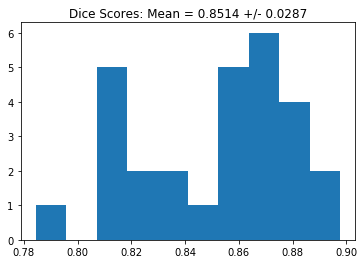

0.7423 +/- 0.0431


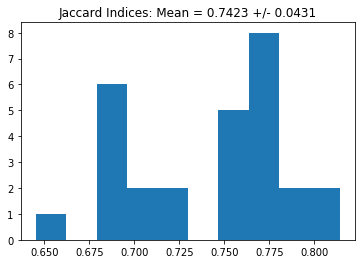

In [7]:
source1 = predict_pd.copy()
source2 = expert1_pd.copy()

source1_seg = np.array(source1.refined_seg_path) #[i + '.npy' for i in np.array(source1.refined_seg_path)]
# source1_seg = list(source1.seg_path)

source2_seg = np.array(source2.refined_seg_path) #[i + '.npy' for i in np.array(source2.refined_seg_path)]
# source2_seg = list(source2.seg_path)


# Get Dice Score 
dice_scores = get_dice_scores(source1_seg, source2_seg)

# Get Jaccard Index
jaccard_indices = get_jaccard_indices(source1_seg, source2_seg)

# Display results
print(np.round(np.mean(dice_scores),4), "+/-",np.round(np.std(dice_scores),4))
plt.hist(dice_scores, bins = 10)
plt.title("Dice Scores: Mean = " + str(np.round(np.mean(dice_scores),4)) + " +/- " + str(np.round(np.std(dice_scores),4)))
plt.show()

print(np.round(np.mean(jaccard_indices),4), "+/-",np.round(np.std(jaccard_indices),4))
plt.hist(jaccard_indices, bins = 10)
plt.title("Jaccard Indices: Mean = " + str(np.round(np.mean(jaccard_indices),4)) + " +/- " + str(np.round(np.std(jaccard_indices),4)))
plt.show()



### See how well they agree in terms of the average T2 value in each cartilage region of each image

In [11]:
source1_regions = list(source1.t2_region_json_path)
source2_regions = list(source2.t2_region_json_path)

correlation_dict, mean_abs_diff_dict = compare_region_means(source1_regions, 
                                                            source2_regions, 
                                                            results_path=None,
                                                            correlation_method = 'pearson')

correlation_dict


{'all': (0.9789003234419682, 1.8533733610170322e-19),
 'superficial': (0.9428523878715533, 6.376901644843228e-14),
 'deep': (0.9837151707821132, 6.566070849470174e-21),
 'SLA': (0.8057847324413598, 2.2928056455642294e-07),
 'SLC': (0.9294661343030262, 9.10930898650833e-13),
 'SLP': (0.9113962308037515, 1.5918358211189767e-11),
 'SUA': (0.7795351547177356, 1.014637521474934e-06),
 'SUC': (0.9508041685926796, 9.5148227545546e-15),
 'SUP': (0.9319505870347455, 5.797376821123323e-13),
 'DLA': (0.9486942521210133, 1.6228230066516468e-14),
 'DLC': (0.9579927576779126, 1.2714362715236388e-15),
 'DLP': (0.9138219950345978, 1.1253185826630455e-11),
 'DUA': (0.9144750630424658, 1.023220938650591e-11),
 'DUC': (0.9215342625443894, 3.4779141476761383e-12),
 'DUP': (0.9470697751077702, 2.4112331587420475e-14),
 'LA': (0.8920561121268652, 1.8522653562051022e-10),
 'LC': (0.9835011966293021, 7.771130111880989e-21),
 'LP': (0.9424066151177917, 7.036749253588396e-14),
 'UA': (0.8757963621487359, 1.0433

### See how well they agree in terms of the average T2 change over time in each cartilage region of each image

In [ ]:
source1_regions2

In [23]:
source1_regions1 = [i for i in source1_regions if i[-6]=='4']# and '9120358' not in i]
source1_regions2 = [i for i in source1_regions if i[-6]=='8']#and '9120358' not in i]
source2_regions1 = [i for i in source2_regions if i[-6]=='4']#and '9120358' not in i]
source2_regions2 = [i for i in source2_regions if i[-6]=='8']#and '9120358' not in i]

if len(source1_regions1)==len(source1_regions2):
    change_correlation_dict, change_mean_abs_diff_dict = compare_region_changes(source1_regions1,
                                                                                source1_regions2, 
                                                                                source2_regions1,
                                                                                source2_regions2, 
                                                                                results_path=None,
                                                                                correlation_method = 'spearman')
change_correlation_dict

    
    

{'all': SpearmanrResult(correlation=0.9604395604395607, pvalue=5.081053892329076e-08),
 'superficial': SpearmanrResult(correlation=0.8813186813186813, pvalue=3.109511008397839e-05),
 'deep': SpearmanrResult(correlation=0.9604395604395607, pvalue=5.081053892329076e-08),
 'SLA': SpearmanrResult(correlation=0.3406593406593406, pvalue=0.23331605103682404),
 'SLC': SpearmanrResult(correlation=0.7054945054945055, pvalue=0.004819557979048519),
 'SLP': SpearmanrResult(correlation=0.7846153846153847, pvalue=0.0008900739749078555),
 'SUA': SpearmanrResult(correlation=0.767032967032967, pvalue=0.0013676823882456158),
 'SUC': SpearmanrResult(correlation=0.8373626373626375, pvalue=0.00018639737783200425),
 'SUP': SpearmanrResult(correlation=0.8945054945054945, pvalue=1.579830848680049e-05),
 'DLA': SpearmanrResult(correlation=0.7538461538461538, pvalue=0.001844725289257219),
 'DLC': SpearmanrResult(correlation=0.9472527472527472, pvalue=2.7738827125448025e-07),
 'DLP': SpearmanrResult(correlation=0

### See how well they agree in terms of the cartilage lesions that are identified as developing over time

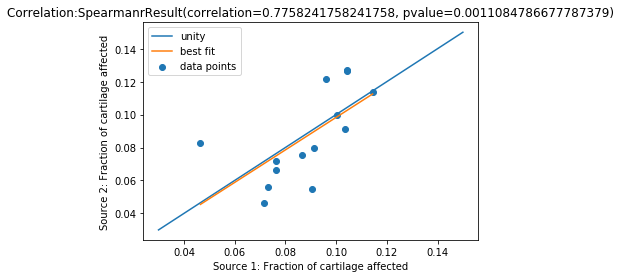


Raw Error: 0.0015585925073320146 +/- 0.011264745776148017

Relative Error: 0.00547087837265503 +/- 0.19287180661054068


In [20]:
plt.scatter(percentLesion_expert1, percentLesion_predict)
plt.title("Correlation:" + str(spearmanr(percentLesion_expert1, percentLesion_predict)))
plt.xlabel("Source 1: Fraction of cartilage affected")
plt.ylabel("Source 2: Fraction of cartilage affected")
plt.plot([.03,.15],[.03,.15])
plt.plot(np.unique(percentLesion_expert1), np.poly1d(np.polyfit(percentLesion_expert1, percentLesion_predict, 1))(np.unique(percentLesion_expert1)))
plt.legend(['unity','best fit','data points'])
plt.show()


bias_raw = np.mean(((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))
StD_raw = np.std(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))

print()    
print("Raw Error:", bias_raw, "+/-", StD_raw)

bias_relative = np.mean(((np.array(percentLesion_expert1) - np.array(percentLesion_predict))/np.array(percentLesion_expert1)))
StD_relative = np.std(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))/np.array(percentLesion_expert1)))
    
print()    
print("Relative Error:", bias_relative, "+/-", StD_relative)
 


In [ ]:
np.mean(np.abs((np.array(percentLesion_expert1) - np.array(percentLesion_predict))))



In [ ]:
with open('/data/kevin_data/qmetric/t2_projected/9909311_4.npy.pickle', 'rb') as handle:
    dict_a = pickle.load(handle)

with open('/data/kevin_data/qmetric/t2_projected/9909311_8.npy.pickle', 'rb') as handle:
    dict_b = pickle.load(handle)
    
a = make_projection_proportional(dict_a)
b = make_projection_proportional(dict_b)
a,b = align_projections(a,b)

In [ ]:
plt.imshow(a)
plt.show()

In [ ]:
plt.imshow(b)
plt.show()

In [ ]:
num_pix = np.sum(b!=0)
where_b = np.where(b)
where_a = np.where(a)

dmap = np.zeros_like(b)
for i in range(num_pix):
    t2_b = b[where_b[0][i], where_b[1][i]]
    
    distances_r = where_a[0] - where_b[0][i]
    distances_c = where_a[1] - where_b[1][i]
    distances = np.sqrt(distances_r**2 + distances_c**2)
    index = np.argmin(distances)
    t2_a = a[where_a[0][index], where_a[1][index]]
    
    change = t2_b - t2_a
    dmap[where_b[0][i], where_b[1][i]] = change
plt.imshow(dmap)

In [ ]:
from difference_map_utils import eroded_and_mask
mask = eroded_and_mask(dmap!=0,dmap!=0)
dmap = dmap*mask
plt.imshow(dmap)

In [ ]:
a= np.array([10,2,1,5])
i = np.argsort(a)
a[i]

In [ ]:
a=np.array([[10,1,5,3],[8,9,7,2],[1,2,3,4],[7,6,5,4]])
a

In [ ]:
a[[0,0,1],[2,3,3]]